In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from PIL import Image
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:
def alternateSequentialFiltering(image):
    # ASF(alternate sequential filtering) Smooth the whole picture
    open1 = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    close1 = cv2.morphologyEx(open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    open2 = cv2.morphologyEx(close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    close2 = cv2.morphologyEx(open2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    open3 = cv2.morphologyEx(close2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    close3 = cv2.morphologyEx(open3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    return close3

def preProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    
    plt.subplot(1,3,1)
    plt.imshow(g, cmap="gray")
    cv2.imwrite('./image/greenchannel/'+str(i)+'_bloodvessel.png', g)
    
    plt.subplot(1,3,2)
    plt.imshow(contrast_g_fundus, cmap="gray")
    cv2.imwrite('./image/clahe/'+str(i)+'_bloodvessel.png', contrast_g_fundus)
    
    plt.subplot(1,3,3)
    plt.imshow(R3, cmap="gray")
    cv2.imwrite('./image/filtering/'+str(i)+'_bloodvessel.png', R3)
    plt.show()

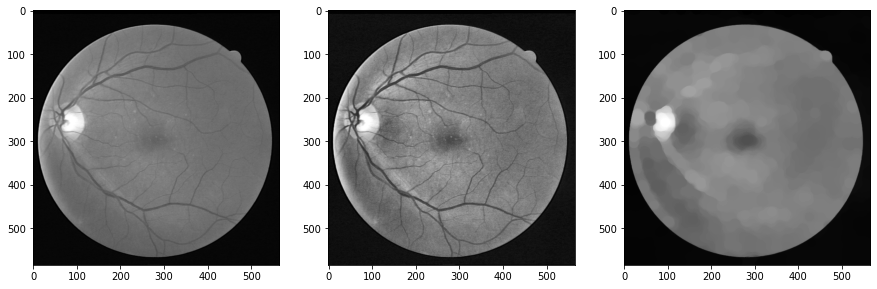

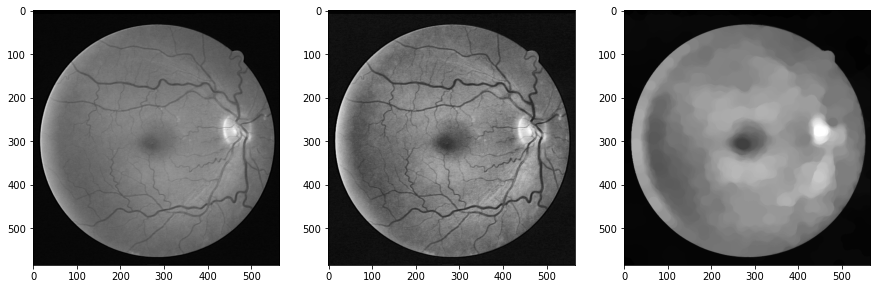

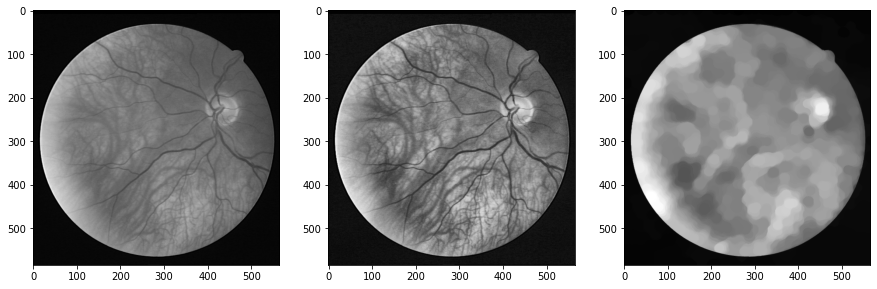

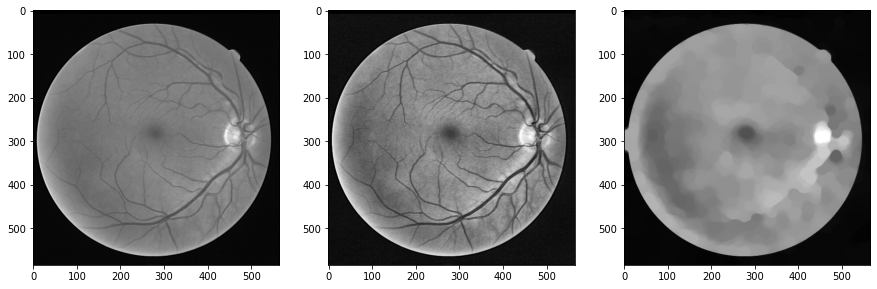

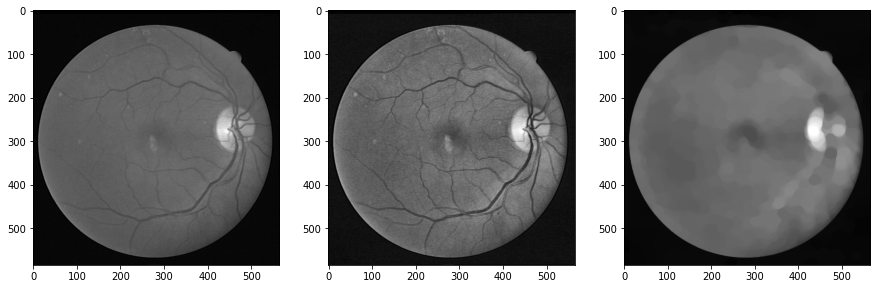

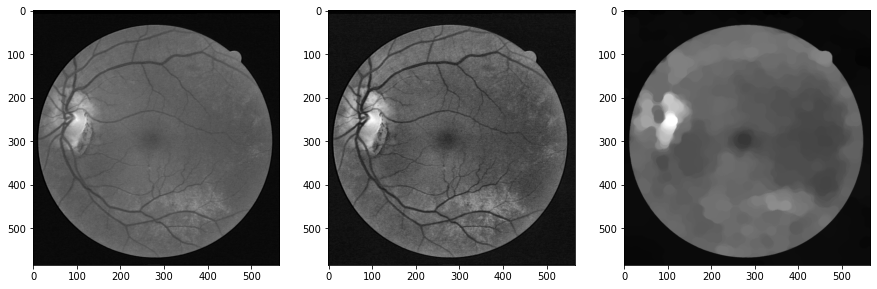

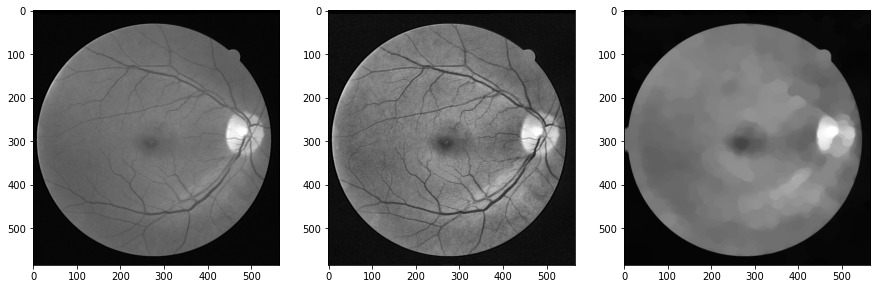

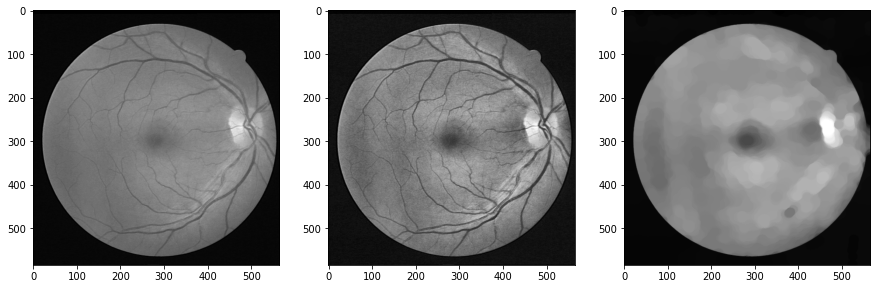

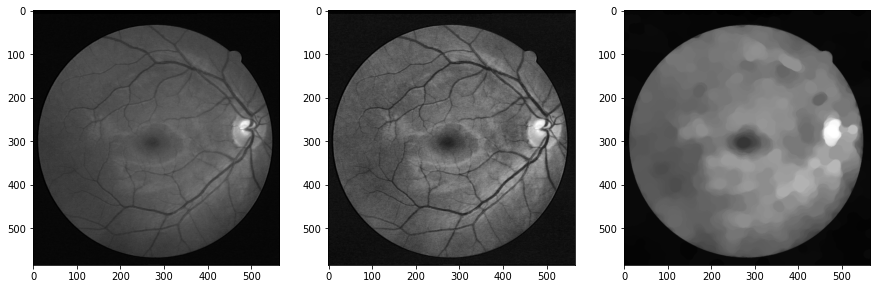

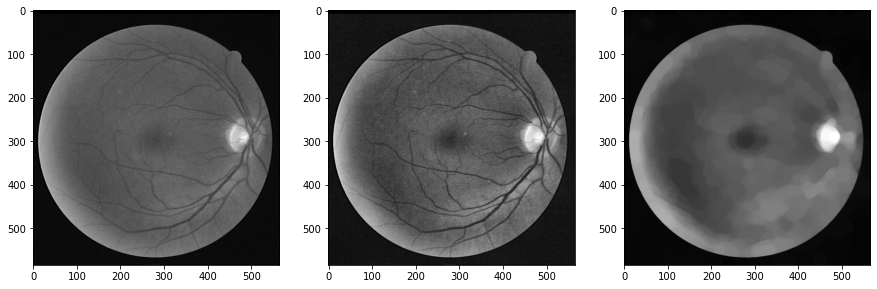

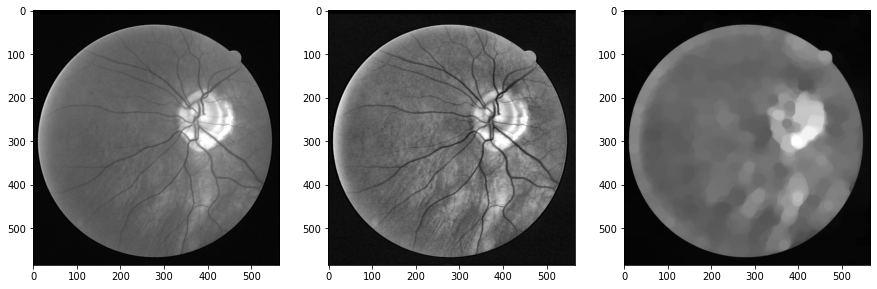

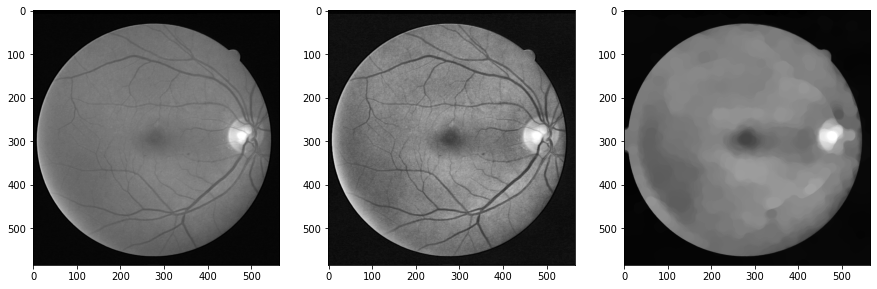

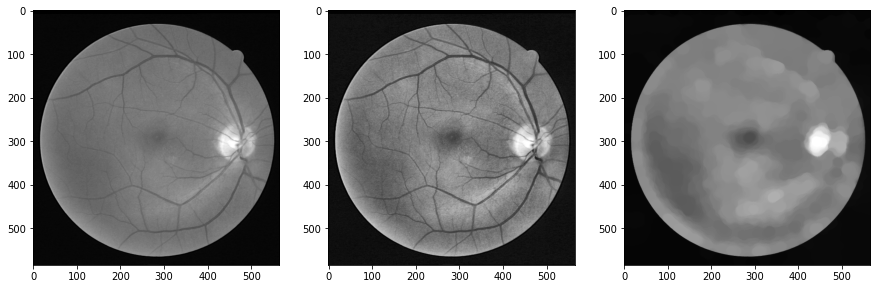

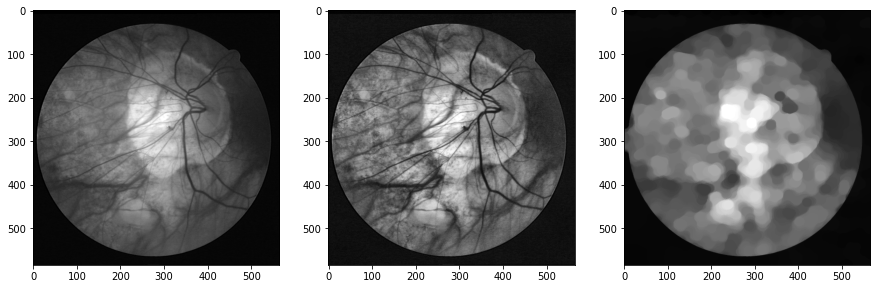

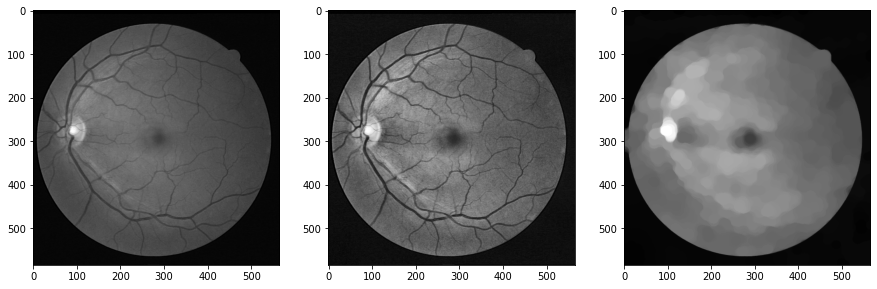

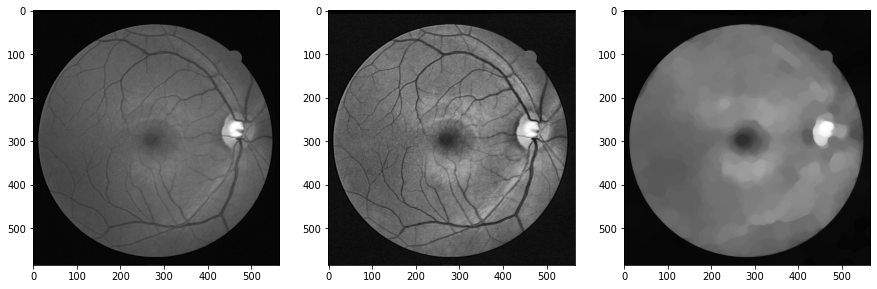

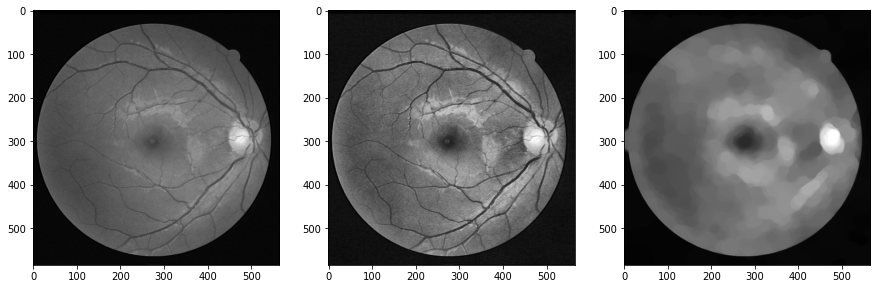

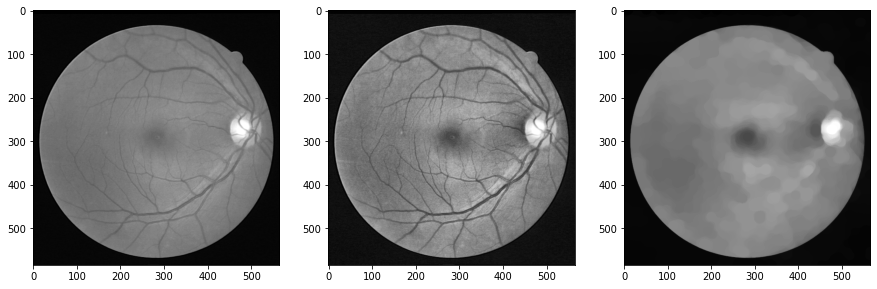

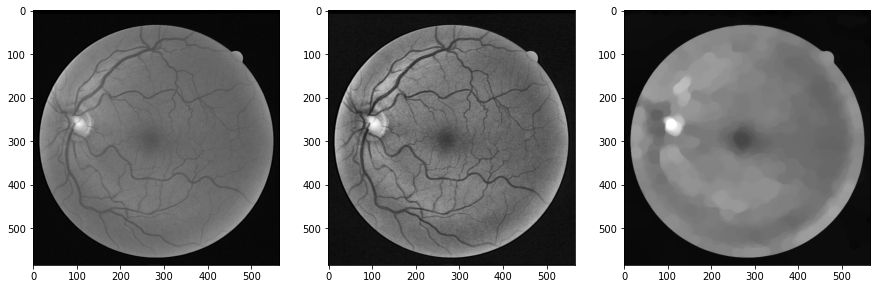

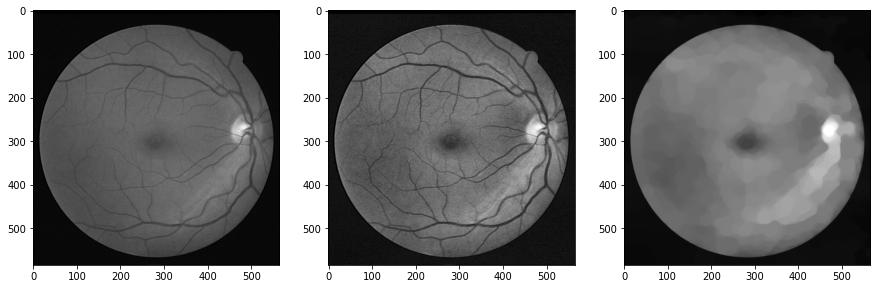

In [3]:
for i in range(21,41):
    preProcess(i)

In [16]:
def postProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    f4 = cv2.subtract(R3, contrast_g_fundus)
    f5 = clahe.apply(f4)
    f6 = clahe.apply(f5)
    f7 = clahe.apply(f6)
    
    _, thresh = cv2.threshold(f7, 15, 255, cv2.THRESH_BINARY)  #mapping array 0 atau 255 (item putih)
    maskSmallContour = np.ones(f7.shape[:2], dtype="uint8") * 255 #mapping array bernilai 255 (utk masking)
    contoursSmall, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #
    for cnts in contoursSmall:
        if cv2.contourArea(cnts) <= 200: 
            cv2.drawContours(maskSmallContour, [cnts], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=maskSmallContour)
    _, fin = cv2.threshold(im, 30, 255, cv2.THRESH_BINARY)

    plt.subplot(1,2,1)
    plt.imshow(im, cmap="gray")
    cv2.imwrite('./image/im/'+str(i)+'_bloodvessel.png', im)
    plt.subplot(1,2,2)
    plt.imshow(fin, cmap="gray")
    cv2.imwrite('./image/firstresult/'+str(i)+'_bloodvessel.png', fin)

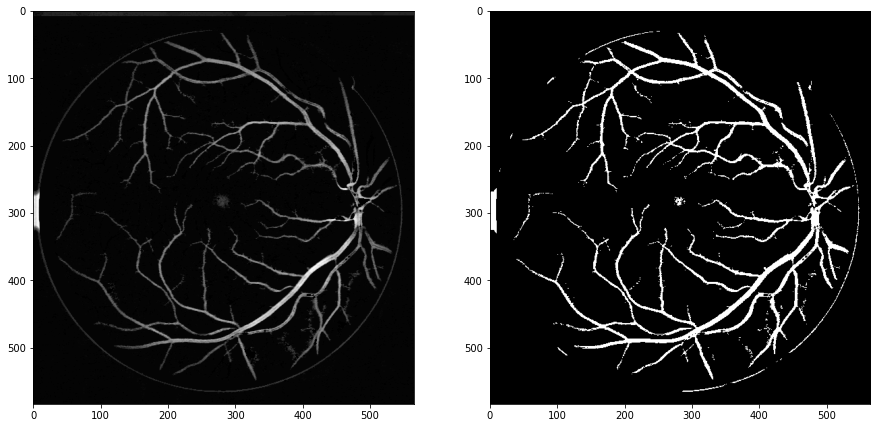

In [17]:
postProcess(24)

In [18]:
from PIL import Image
def removeBoarder(i):
    im = Image.open('training/mask/'+str(i)+'_training_mask.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    image = cv2.imread('image/firstresult/'+str(i)+'_bloodvessel.png')
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(I, kernel, iterations=3)
    result = cv2.bitwise_and(erosion, image)
    
    plt.subplot(1,3,1)
    plt.imshow(image, cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(erosion, cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(result, cmap="gray")
    cv2.imwrite('image/lastresult/'+str(i)+'_bloodvessel.png', result)

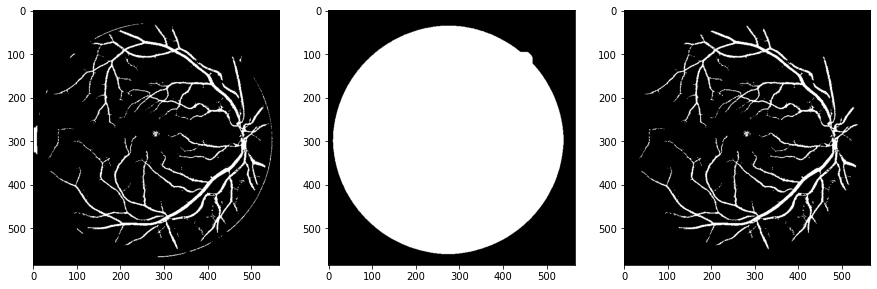

In [19]:
removeBoarder(24)

In [36]:
from skimage import img_as_bool, color, morphology, io
import PIL.ImageOps 
def skeletonize(i):
    image = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    image = img_as_bool(color.rgb2gray(image))
    out = morphology.medial_axis(image)
    
    plt.subplots(figsize=(12, 12))
    plt.imshow(out, cmap="gray")
    io.imsave('image/skeleton/'+str(i)+'_bloodvessel.png',out)
    
def invert_image(i):
    image = cv2.imread('image/skeleton/'+str(i)+'_bloodvessel.png')
    invert = cv2.bitwise_not(image) # OR
    
    plt.subplots(figsize=(12, 12))
    plt.imshow(invert, cmap="gray")
    cv2.imwrite('image/invert_image/'+str(i)+'_bloodvessel.png', invert)

d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: image/skeleton/21_bloodvessel.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  # Remove the CWD from sys.path while we load stuff.
d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: image/skeleton/22_bloodvessel.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  # Remove the CWD from sys.path while we load stuff.
d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: image/skeleton/23_bloodvessel.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  # Remove the CWD from sys.path while we load stuff.
d:\users\asus\appdata\local\

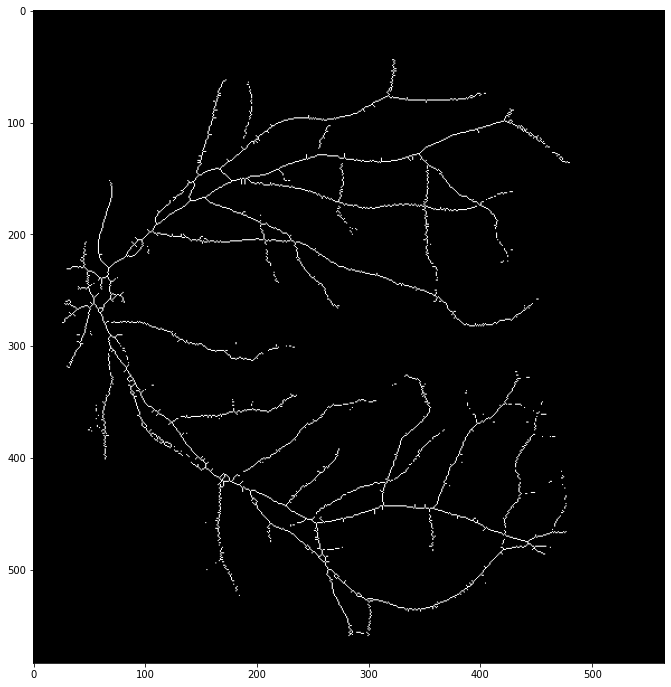

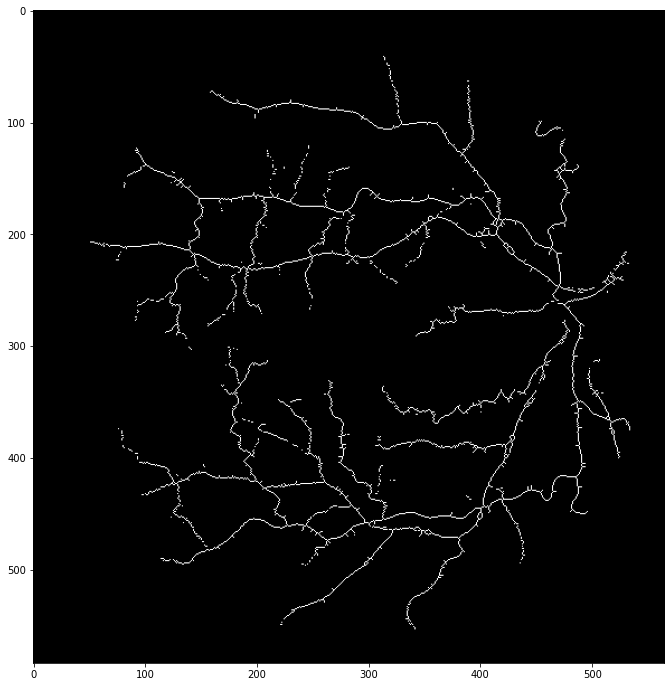

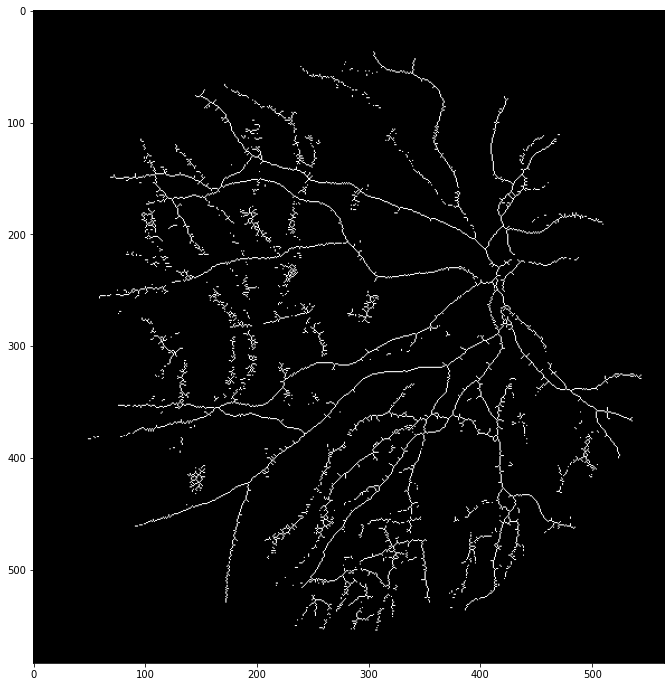

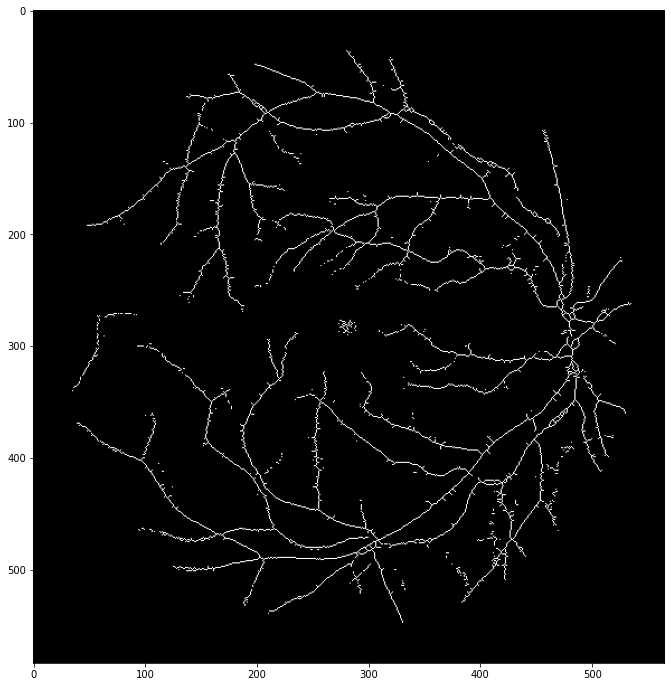

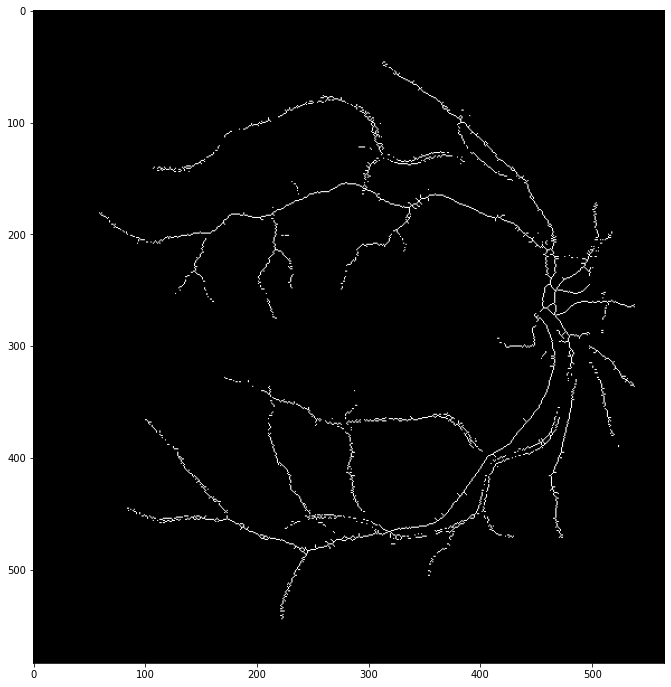

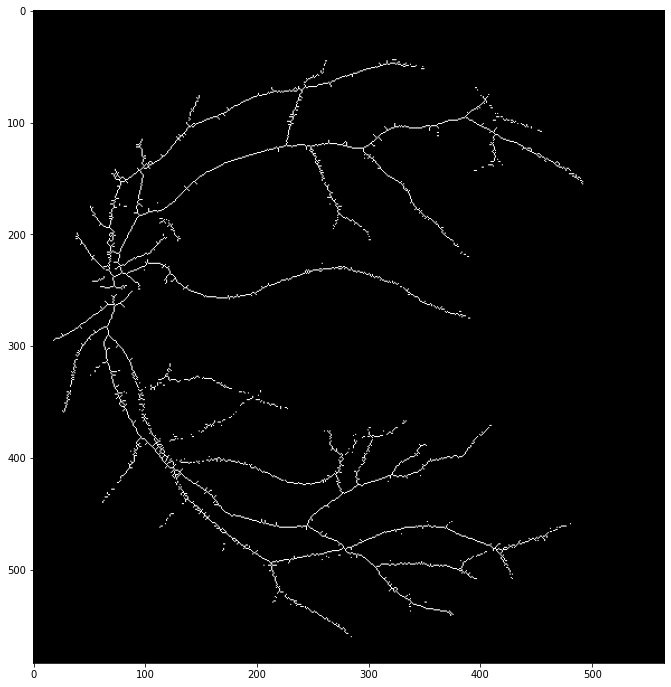

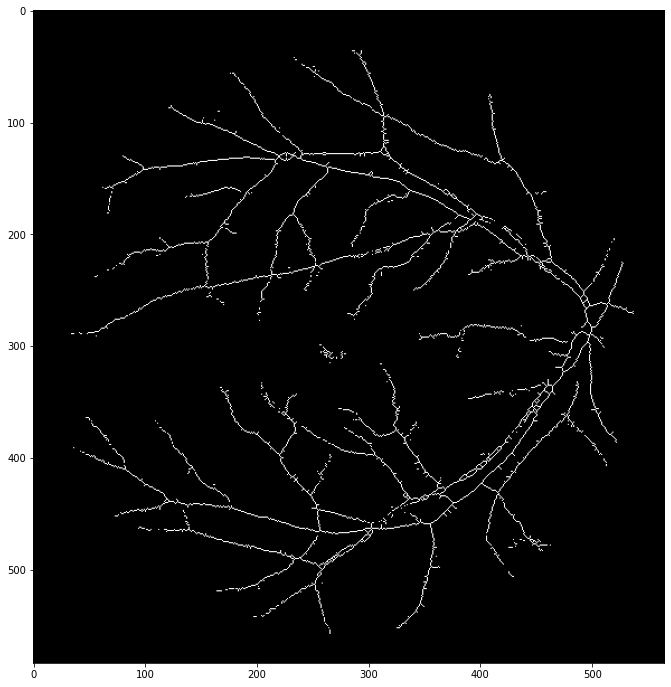

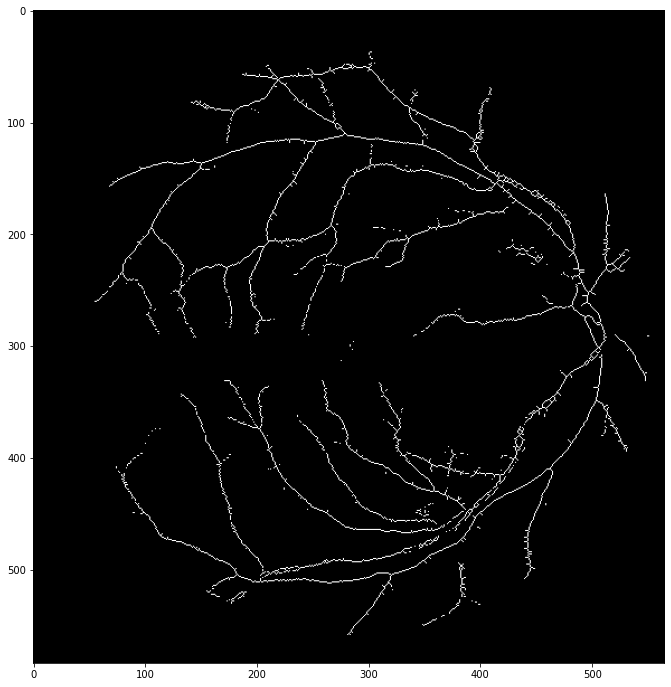

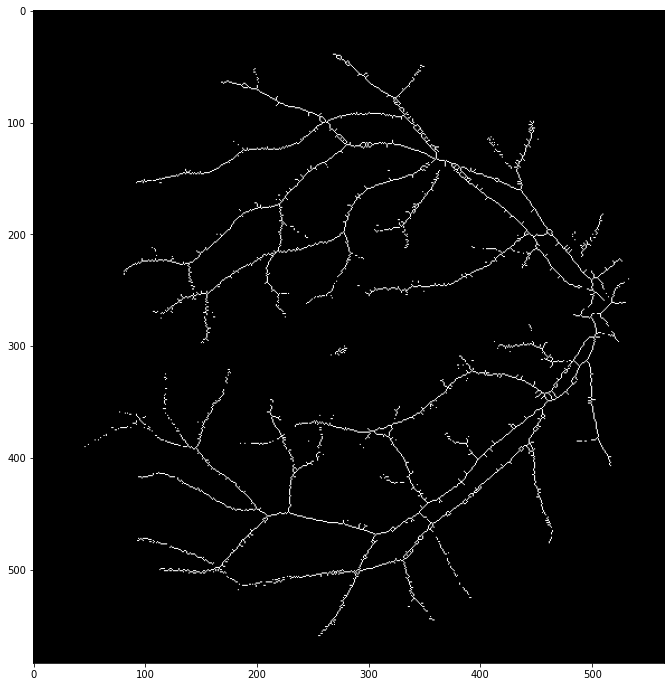

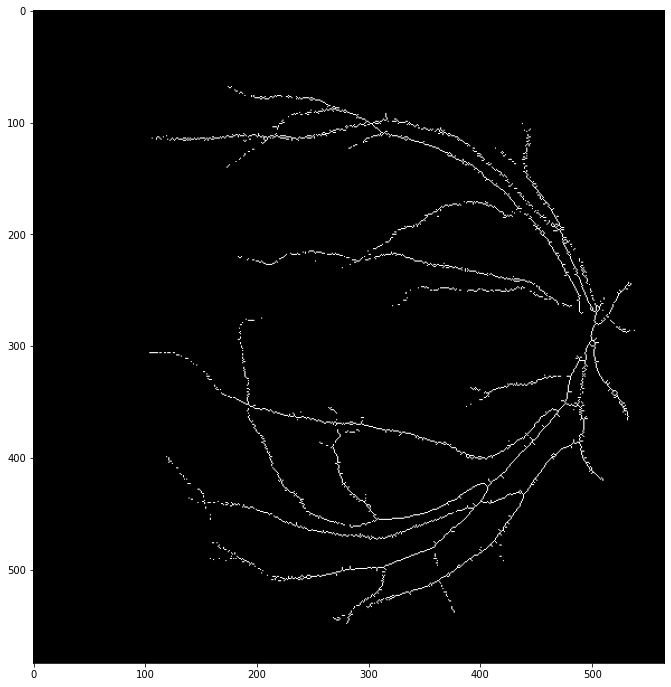

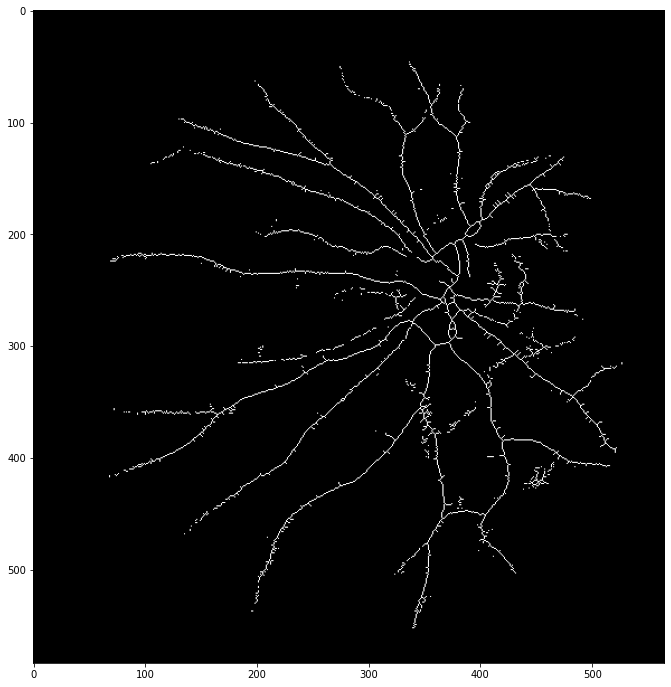

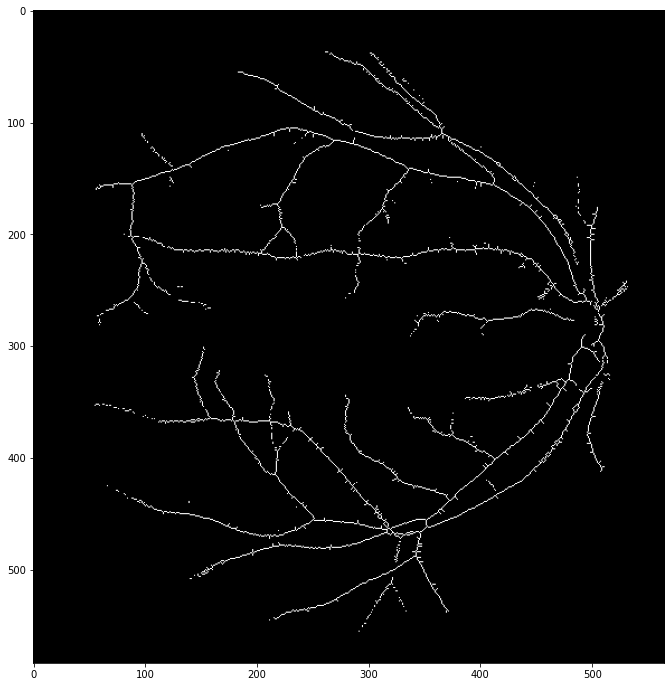

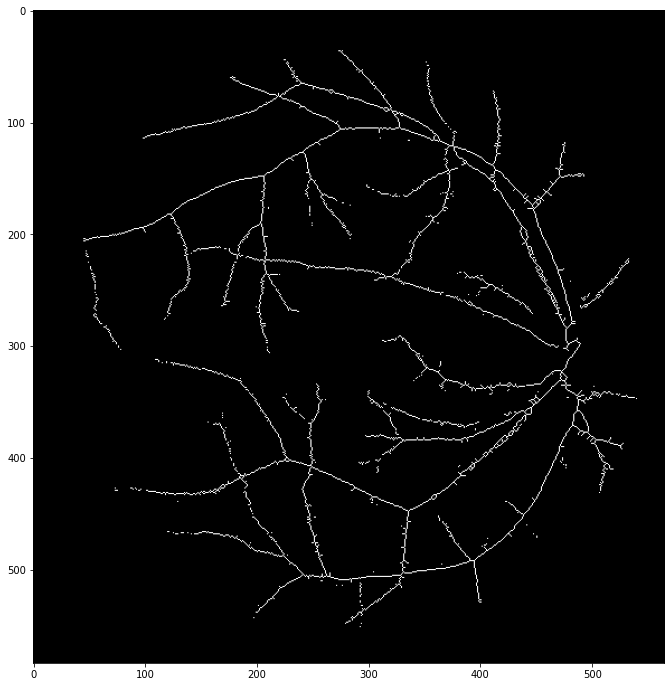

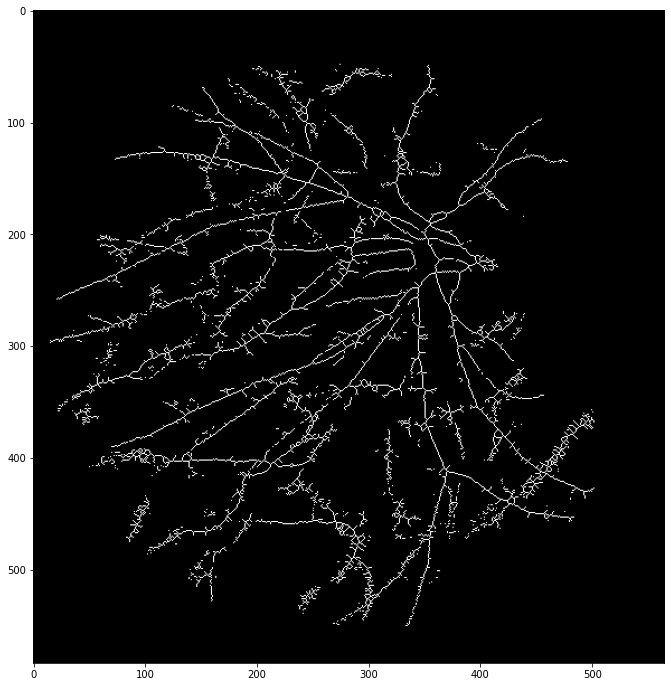

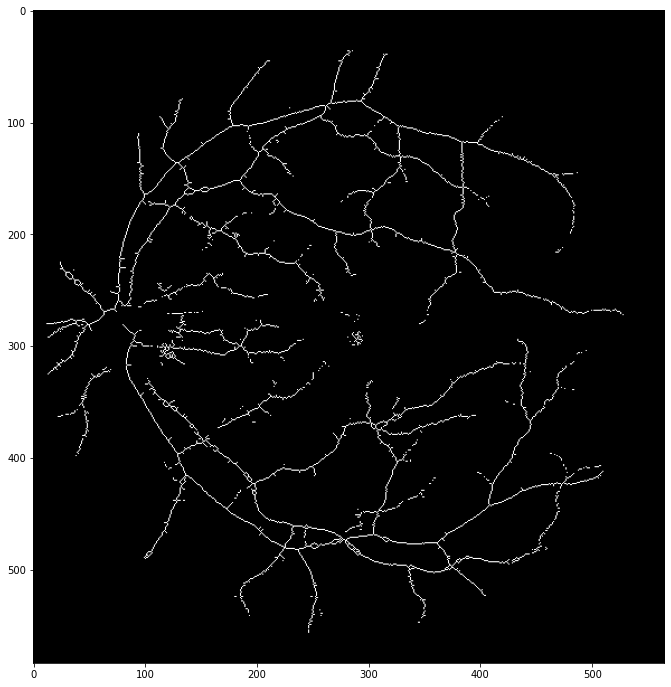

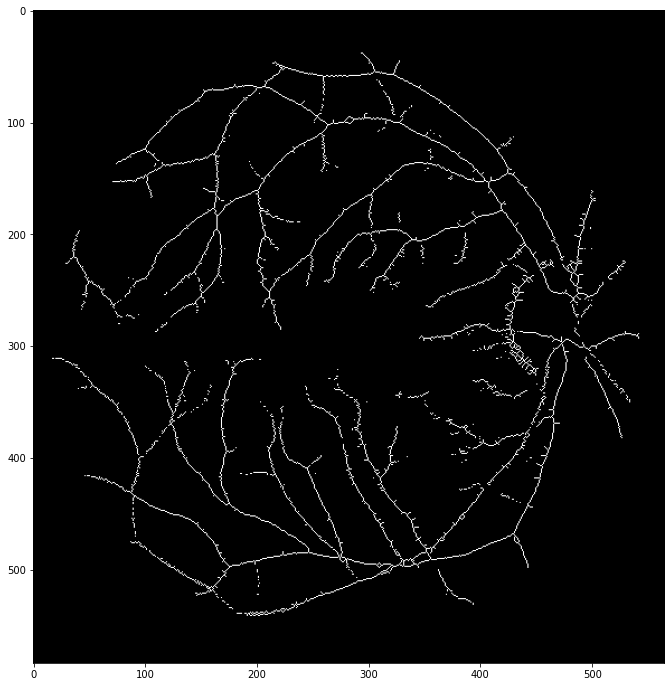

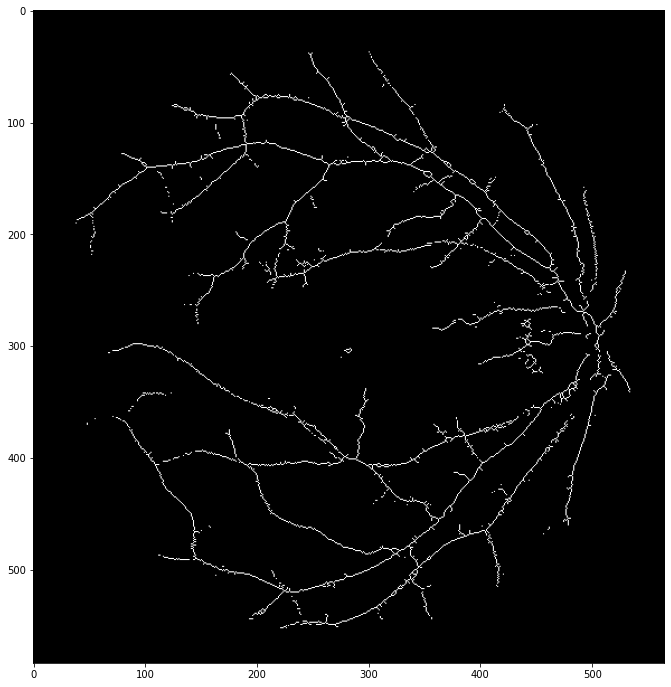

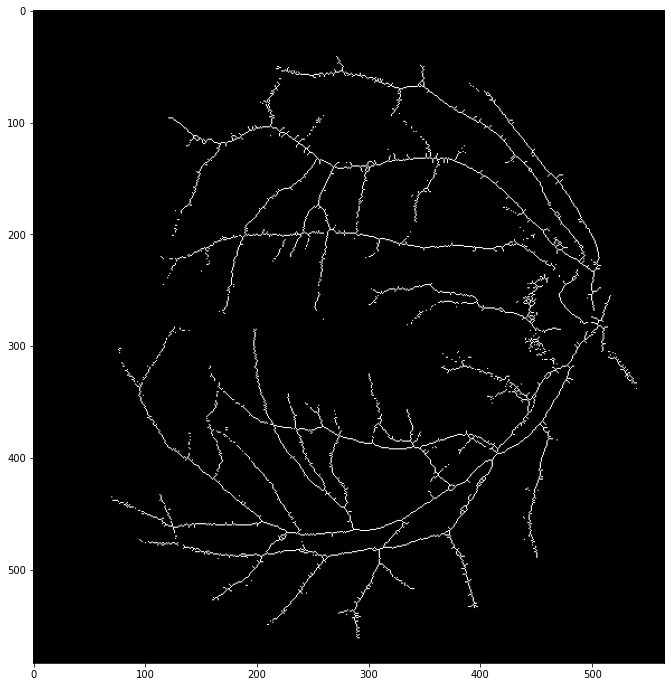

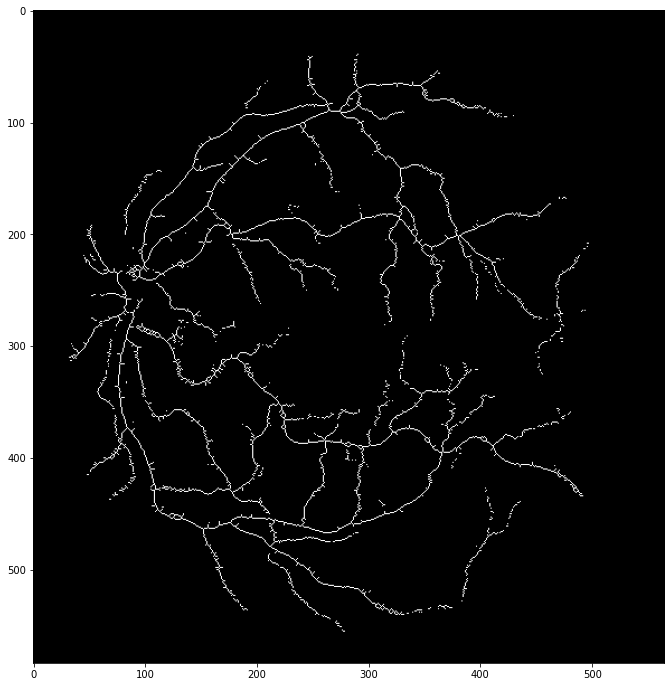

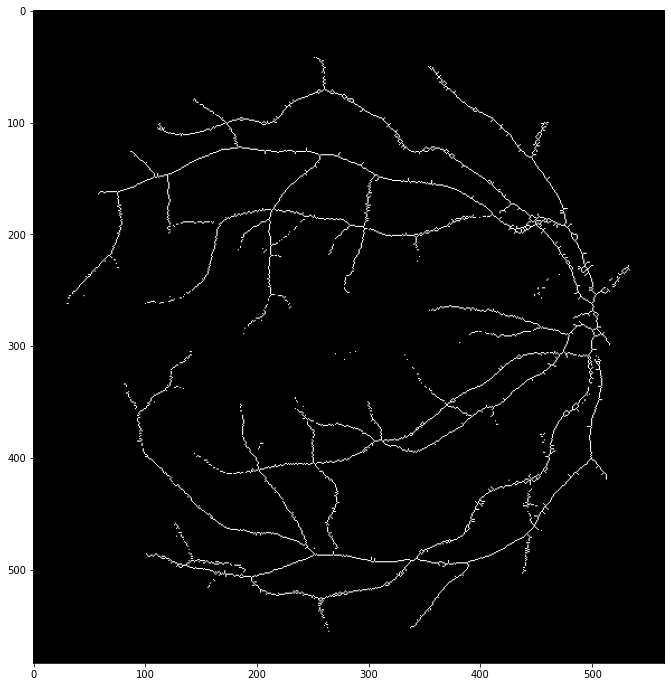

In [37]:
for i in range(21,41):
    skeletonize(i)

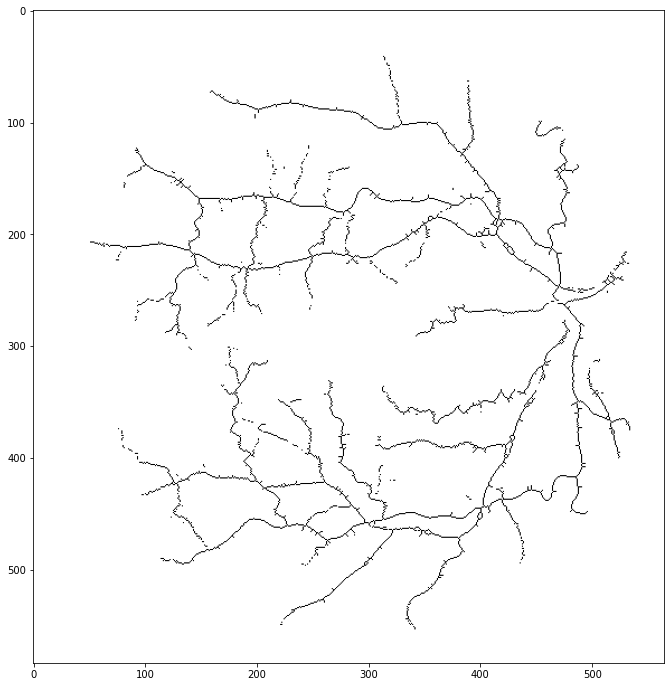

In [38]:
invert_image(22)

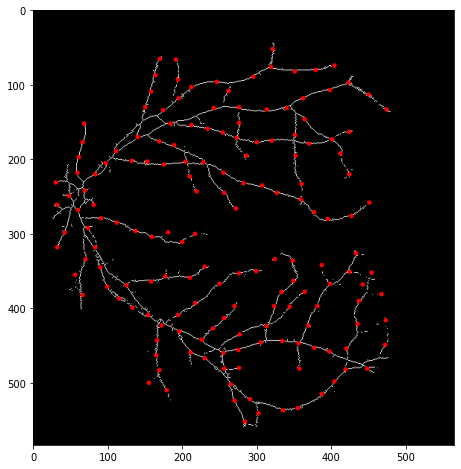

(<matplotlib.image.AxesImage at 0x279bb812c88>, None)

In [9]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('image/skeleton/21_bloodvessel.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(gray,1000,0.01,20)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),3,255,-1)
plt.imshow(img),plt.show()


d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:88: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


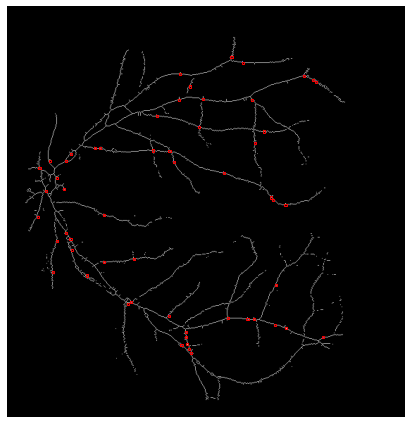

In [11]:
import io
import numpy as np    
from PIL import Image
from scipy import ndimage
from IPython.display import display # to display images
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
from skimage.segmentation import clear_border
from skimage.color import label2rgb

image_string = open('image/skeleton/21_bloodvessel.png', 'rb').read()
img = Image.open(io.BytesIO(image_string))
arr = np.asarray(img)

structure = [
    [
        [0,1,0],
        [1,1,1],
        [0,1,0]
    ],
    [
        [0,1,0],
        [0,1,0],
        [1,0,1]
    ],
    [
        [1,1,0],
        [0,0,1],
        [1,1,1]
    ],
    [
        [0,1,0],
        [1,1,1],
        [1,0,1]
    ],
    [
        [0,1,0],
        [1,0,1],
        [1,0,1]
    ],
    [
        [1,0,1],
        [1,0,1],
        [0,1,0]
    ],
    [
        [1,0,1],
        [1,0,1],
        [1,1,1]
    ],
    [
        [1,1,1],
        [1,0,0],
        [1,1,1]
    ],
    [
        [1,1,1],
        [1,0,0],
        [1,0,0]
    ],
    [
        [0,0,1],
        [0,0,1],
        [1,1,1]
    ],
    [
        [1,0,1],
        [0,1,0],
        [1,0,1]
    ],
    [
        [0,0,0,0,1],
        [0,0,0,0,1],
        [0,0,0,0,1],
        [0,0,0,0,1],
        [1,1,1,1,1],
    ],
    [
        [0,0,1,0,0],
        [0,0,1,0,0],
        [0,1,1,1,0],
        [1,0,1,0,1],
        [1,0,1,0,1],
    ],
]
result = 0
for struct in structure:
    result = result + ndimage.binary_hit_or_miss(arr, struct).astype(np.int)
# founded = np.where(result == 1)
result=morphology.dilation(result)

# remove artifacts connected to image border
cleared = clear_border(result)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=arr, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 1:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


d:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("OrRd").copy()


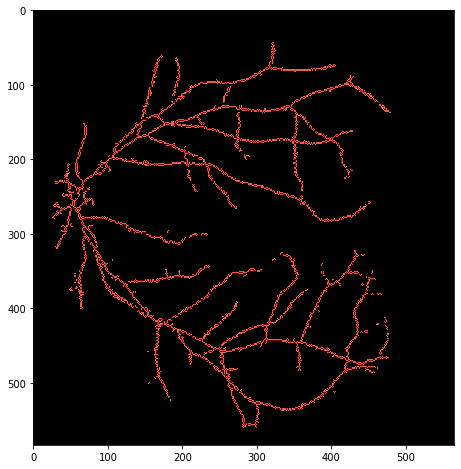

In [20]:
import numpy as np
import scipy.ndimage as snd

import matplotlib.pyplot as plt

A = arr
A_orthog = A.copy() #this will be the copy we update to have orthogonal neighbors
#Two diagonal kernels
K_diag_upslope = np.array([[0,0,0],[0,0,1],[0,1,0]])
K_diag_downslope = np.array([[0,0,0],[1,0,0],[0,1,0]])
#Convolve each one, one at a time, and save new points to A_orthog
#Note: the variable B is always an intermediary so I overwrite it every time
B = snd.convolve(1*A,K_diag_upslope, mode='constant')
A_orthog[B==2] = 1
B = snd.convolve(1*A,K_diag_downslope, mode='constant')
A_orthog[B==2] = 1

#Now A_orthog should be ready for the method shown in my first bit of code up above

K1 = snd.generate_binary_structure(2,1)
print(B)
B = snd.convolve(1*A_orthog,K1, mode='constant')
image_of_branch_points = B>=4

Abranch = 120*A + 240*image_of_branch_points

cmap = plt.cm.OrRd
cmap.set_under(color='black')
plt.imshow(Abranch, interpolation='none', cmap=cmap, vmin=0.01)

In [12]:
import cv2
import numpy as np

img = cv2.imread('image/skeleton/21_bloodvessel.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template = cv2.imread('image/skeleton/template/1.png', cv2.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]

result = cv2.matchTemplate(gray_img, template, cv2.TM_CCOEFF_NORMED)
loc = np.where(result >= 0.4)

for pt in zip(*loc[::-1]):
    cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 3)

cv2.imshow("img", img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [27]:
import cv2
import numpy as np

# load image, ensure binary, remove bar on the left
input_image = cv2.imread('image/skeleton/21_bloodvessel.png', 0)
input_image = cv2.threshold(input_image, 0, 255, cv2.THRESH_BINARY)[1]

kernel = np.array((
        [1, 1, 1],
        [1, 0, 0],
        [1, 0, 0]), dtype="int")
# kernel = np.array([[0, 0, 0, 0, 0, 0, 0],
#                     [0, 0, 0, 1, 0, 0, 0],
#                     [0, 0, 1, 0, 1, 0, 0],
#                     [0, 1, 0, 0, 0, 1, 0],
#                     [1, 0, 0, 0, 0, 0, 1]
#                    ], np.uint8)
# kernel = np.array([[0, 0, 0, 0, 0, 0, 0],
#                     [0, 0, 0, 1, 0, 0, 0],
#                     [0, 0, 1, 1, 1, 0, 0],
#                     [0, 1, 0, 1, 0, 1, 0],
#                     [1, 0, 0, 1, 0, 0, 1]
#                    ], np.uint8)
# kernel = np.array([
#                     [0, 1, 0, 0, 0, 1, 0],
#                     [0, 0, 1, 0, 1, 0, 0],
#                     [0, 0, 0, 1, 0, 0, 0],
#                     [0, 0, 1, 0, 1, 0, 0],
#                     [0, 1, 0, 0, 0, 1, 0]
#                    ], np.uint8)
output_image = cv2.morphologyEx(input_image, cv2.MORPH_HITMISS, kernel)
# rate = 50
# kernel = (kernel + 1) * 127
# kernel = np.uint8(kernel)
# kernel = cv2.resize(kernel, None, fx = rate, fy = rate, interpolation = cv2.INTER_NEAREST)
cv2.imshow("Input image", input_image)
cv2.moveWindow("Input image", 0, 0)
# input_image = cv2.resize(input_image, None, fx = rate, fy = rate, interpolation = cv2.INTER_NEAREST)
# cv2.imshow("Original", input_image)
# cv2.moveWindow("Original", 0, 200)
# output_image = cv2.resize(output_image, None , fx = rate, fy = rate, interpolation = cv2.INTER_NEAREST)
cv2.imshow("Hit or Miss", output_image)
cv2.moveWindow("Hit or Miss", 500, 200)

if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

In [ ]:
def skeleton_endpoints(skel):
    # Make our input nice, possibly necessary.
    skel = skel.copy()
    skel[skel!=0] = 1
    skel = np.uint8(skel)

    # Apply the convolution.
    kernel = np.uint8([[1,  1, 1],
                       [1, 10, 1],
                       [1,  1, 1]])
    src_depth = -1
    filtered = cv2.filter2D(skel,src_depth,kernel)

    # Look through to find the value of 11.
    # This returns a mask of the endpoints, but if you
    # just want the coordinates, you could simply
    # return np.where(filtered==11)
    out = np.zeros_like(skel)
    out[np.where(filtered==11)] = 1
    return out

In [28]:
import io
import numpy as np    
from PIL import Image
from scipy import ndimage
from IPython.display import display # to display images

image = cv2.imread('image/skeleton/21_bloodvessel.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 100:
        cv2.drawContours(opening, [c], -1, (0,0,0), -1)

cv2.imshow('thresh', thresh)
cv2.imshow('opening', opening)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

In [11]:
import cv2
import numpy

frame = cv2.imread('image/invert_image/21_bloodvessel.png')

if frame is None:
    print('Error loading image')
    exit()

colour_frame = frame

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

ret, frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY)

rows = frame.shape[0]
cols = frame.shape[1]
branch_locations = []

# start with second column
for i in range(0, cols):
    lit = False
    begin_black_regions = []
    end_black_regions = []

    # start with first row
    if 0 == frame[0, i]:
        lit = True
    else:
        lit = False
    begin_black_regions.append(0)

    # start with second row
    for j in range(1, rows - 1):
        if 0 == frame[j, i] and lit == False:
            lit = True
            end_black_regions.append(j - 1)
        elif 255 == frame[j, i] and lit == True:
            lit = False
            begin_black_regions.append(j)

    # end with last row
    if 255 == frame[rows - 1, i] and lit == False:
        end_black_regions.append(rows - 1)
    elif 255 == frame[rows - 1, i] and lit == True:
        begin_black_regions.append(rows - 1)
        end_black_regions.append(rows - 1)
    elif 0 == frame[rows - 1, i] and lit == False:
        end_black_regions.append(rows - 2)

    for k in range(0, len(begin_black_regions)):
        found_branch = True
        
        for l in range(begin_black_regions[k], end_black_regions[k] + 1):
            if 255 == frame[l, i - 1]:
                found_branch = False
                break

        if found_branch == True:
            branch_locations.append(complex(i - 1, begin_black_regions[k]))
                
for i in range(0, len(branch_locations)):
    cv2.circle(colour_frame, (int(branch_locations[i].real), int(branch_locations[i].imag)), 6, (255, 127, 0), 2)
cv2.imshow("Frame", colour_frame)

cv2.waitKey(0)

-1

In [21]:
import cv2
import numpy

frame = cv2.imread('image/skeleton/21_bloodvessel.png')

if frame is None:
    print('Error loading image')
    exit()

colour_frame = frame

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

ret, frame = cv2.threshold(frame, 125, 255, cv2.THRESH_BINARY)

rows = frame.shape[0]
cols = frame.shape[1]
branch_locations = []

# start with second column
for i in range(1, cols):
    lit = False
    begin_black_regions = []
    end_black_regions = []

    # start with first row
    if 255 == frame[0, i]:
        lit = True
    else:
        lit = False
    begin_black_regions.append(0)

    # start with second row
    for j in range(1, rows - 1):
        if 255 == frame[j, i] and lit == False:
            lit = True
            end_black_regions.append(j - 1)
        elif 0 == frame[j, i] and lit == True:
            lit = False
            begin_black_regions.append(j)

    # end with last row
    if 0 == frame[rows - 1, i] and lit == False:
        end_black_regions.append(rows - 1)
    elif 0 == frame[rows - 1, i] and lit == True:
        begin_black_regions.append(rows - 1)
        end_black_regions.append(rows - 1)
    elif 255 == frame[rows - 1, i] and lit == False:
        end_black_regions.append(rows - 2)

    for k in range(0, len(begin_black_regions)):
        found_branch = True
        
        for l in range(begin_black_regions[k], end_black_regions[k] + 1):
            if 0 == frame[l, i - 1]:
                found_branch = False
                break

        if found_branch == True:
            branch_locations.append(complex(i - 1, begin_black_regions[k]))
                
for i in range(0, len(branch_locations)):
    cv2.circle(colour_frame, (int(branch_locations[i].real), int(branch_locations[i].imag)), 6, (255, 127, 0), 2)
cv2.imshow("Frame", colour_frame)

cv2.waitKey(0)

-1

KeyboardInterrupt: 

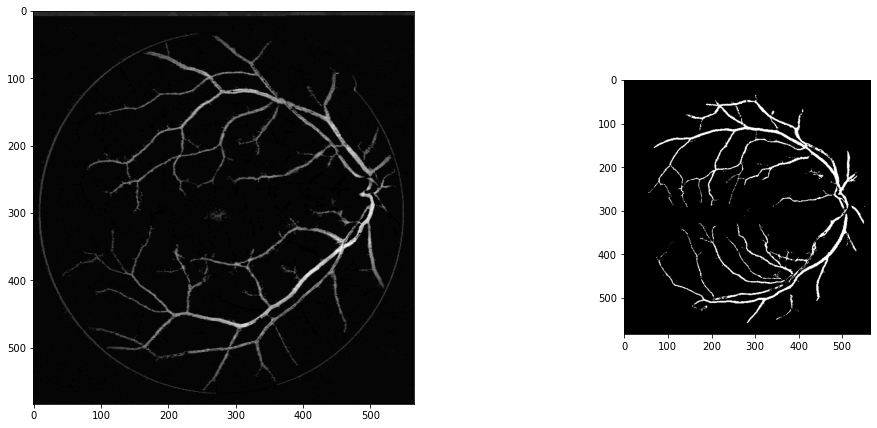

In [75]:
#generate 20 predict images
for i in range(21,41):
    postProcess(i)
    removeBoarder(i)

In [ ]:
def showPicture(i):
    predict = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    origin = cv2.imread('training/images/'+str(i)+'_training.tif')
    origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    plt.subplot(1,3,1)
    plt.imshow(origin), plt.title(f"image {i}", {"fontsize": 20})
    plt.subplot(1,3,2), plt.title(f"manual {i}", {"fontsize": 20})
    plt.imshow(label, cmap="gray")
    plt.subplot(1,3,3), plt.title(f"predict {i} ", {"fontsize": 20})
    plt.imshow(predict, cmap="gray")
    plt.show()

In [ ]:
showPicture(21)

In [ ]:
tn, fp, fn, tp = 0, 0, 0, 0

def accuracy(i):
    global tn, fp, fn, tp
    predict = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    for i in range(predict.shape[0]):                 
        for j in range(predict.shape[1]):
            if(predict[i,j].all()==I[i,j].all()):
                if(predict[i,j].all()==1):
                    tp+=1
                else:
                    tn+=1
            else:
                if(predict[i,j].all()==1):
                    fp+=1
                else:
                    fn+=1
   
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    print('current accuracy '+str(accuracy))

In [ ]:
for i in range(21, 41):
    accuracy(i)

In [ ]:
labels = ['person1', 'person2', 'person3','person4','person5', 'person6', 'person7','person8','person9','person10']
values = [0.961, 0.951, 0.953, 0.954, 0.953, 0.952, 0.952 , 0.953, 0.953, 0.953]
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 8))
graph = ax.bar(x, values, width=0.8, color='lightblue')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(graph)
plt.xlabel('Person ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy of the segmentation results',fontsize=20)
plt.show()